In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append("/home/pervinco/BKAI_MetaPolyp")

import cv2
import yaml
import copy
import random
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from glob import glob
from scipy import ndimage
from data.batch_preprocess import load_img_mask, train_img_mask_transform
from utils.utils import decode_mask, decode_image, visualize

In [2]:
with open("/home/pervinco/BKAI_MetaPolyp/config.yaml", "r") as f:
    config = yaml.safe_load(f)

data_dir = config["data_dir"]
image_dir = f"{data_dir}/train"
mask_dir = f"{data_dir}/train_mask"
gt_dir = f"{data_dir}/train_gt"

In [3]:
image_files = sorted(glob(f"{image_dir}/*"))
mask_files = sorted(glob(f"{mask_dir}/*"))
gt_files = sorted(glob(f"{gt_dir}/*"))

In [4]:
paste_transform = A.Compose([A.OneOf([A.CLAHE(p=0.3),
                                      A.Sharpen(p=0.3),
                                      A.RandomBrightnessContrast(p=0.3),], p=1), 
                            
                             A.OneOf([A.HorizontalFlip(p=0.25),
                                      A.VerticalFlip(p=0.25)], p=1),

                              A.OneOf([A.OpticalDistortion(border_mode=0, p=0.5),
                                       A.GridDistortion(border_mode=0, p=0.5)], p=0.3),

                              A.OneOf([A.Blur(p=0.3), 
                                       A.GaussianBlur(p=0.3),  
                                       A.Sharpen(p=0.3),], p=0.4),])

In [5]:
def spatially_exclusive_pasting(image, mask, alpha=0.7, iterations=10, transform=None):
    target_image, target_mask = copy.deepcopy(image), copy.deepcopy(mask)
    L_gray = cv2.cvtColor(target_mask, cv2.COLOR_BGR2GRAY)

    hs, ws = np.where(L_gray == 1)
    if not hs.any() or not ws.any():
        return target_mask

    he, we = hs.max(), ws.max()
    hs, ws = hs.min(), ws.min()
    
    Lf_gray = L_gray[hs:he, ws:we]
    If = target_image[hs:he, ws:we]
    Lf_color = target_mask[hs:he, ws:we]
    
    M = np.random.rand(*target_image.shape[:2])
    M[L_gray == 1] = float('inf')
    
    height, width = he - hs, we - ws
    for _ in range(iterations):
        crop_image = copy.deepcopy(If)
        crop_mask = copy.deepcopy(Lf_color)
        if transform != None:
            crop_image, crop_mask = train_img_mask_transform(paste_transform, crop_image, crop_mask)

        px, py = np.unravel_index(M.argmin(), M.shape)        
        candidate_area = (slice(px, px + height), slice(py, py + width))
        
        if candidate_area[0].stop > target_image.shape[0] or candidate_area[1].stop > target_image.shape[1]:
            M[px, py] = float('inf')
            continue
        
        if np.any(L_gray[candidate_area] & Lf_gray):
            M[candidate_area] = float('inf')
            continue
        
        target_image[candidate_area] = alpha * target_image[candidate_area] + (1 - alpha) * crop_image
        target_mask[candidate_area] = alpha * target_mask[candidate_area] + (1 - alpha) * crop_mask
        L_gray[candidate_area] = cv2.cvtColor(target_mask[candidate_area], cv2.COLOR_BGR2GRAY)
        
        M[candidate_area] = float('inf')
        
        kernel = np.ones((3, 3), np.float32) / 9
        M = cv2.filter2D(M, -1, kernel)

    return target_image, target_mask

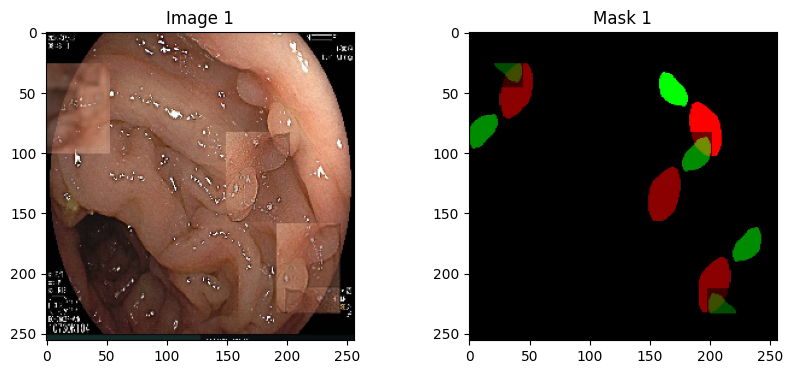

In [30]:
total_files = list(zip(image_files, mask_files))
random.shuffle(total_files)

for image_file, mask_file in total_files:
    image, mask = load_img_mask(image_file, mask_file)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    result_image, result_mask = spatially_exclusive_pasting(image, mask, alpha=0.45, transform=paste_transform)

    visualize([result_image], [result_mask])

    break